In [1]:
import os
import math
import time
from marvin import config

config.setRelease('DR16')
config.setDR('DR16')
config.download = True

from marvin.tools.image import Image
from marvin.tools import Maps
from marvin.tools import Cube

import numpy as np

import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astropy.io import fits

with fits.open('./data/galaxies_sorted.fits') as hdulist:
    plateifu_list = hdulist[1].data['plateifu']
    ra = hdulist[1].data['RA']
    dec = hdulist[1].data['Dec']
    z_list = hdulist[1].data['z']

mapnames = 'maps.emline_gflux_ha_6564'
errormap = ''

lofar_file_path = './data/lofar_imgs/'
lofar_list = os.listdir(lofar_file_path)

with fits.open('./data/angles.fits') as hdulist:
    angles_list = hdulist[1].data['col2']

angles_list[11] = 110
angles_list[10] = 125
angles_list[12] = -70
angles_list[13] = -140

from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

/home/mjlang/miniconda3/lib/python3.8/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 25] Inappropriate ioctl for device.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),
[INFO]: No release version set. Setting default to DR15


In [2]:
def get_dl(sample):  # luminosity distance in cm
    dl = cosmo.luminosity_distance(z_list[sample]).to_value(unit='cm')
    return dl


def get_ha(sample):  # get h-alpha emission map
    maps = Maps(plateifu=plateifu_list[sample])
    ha = maps.emline_gflux_ha_6564
    return ha


def get_er(sample):  # get effective radii map
    maps = Maps(plateifu=plateifu_list[sample])
    er = maps.spx_ellcoo_r_re
    return er


def get_ha_snr(sample):  # get h-alpha emission snr map
    maps = Maps(plateifu=plateifu_list[sample])
    ha = maps.emline_gflux_ha_6564
    ha_snr = ha.snr
    return ha_snr


''' 
def masked_image(sample, min_snr, max_radii): # remain the unit of erg / s spaxel cm^2
    ha = get_ha(sample)
    er = get_er(sample)
    drpall_mask = ha.pixmask.get_mask(['DONOTUSE', 'UNRELIABLE','NOCOV'],dtype=bool)
    snr_mask = (ha.snr < min_snr) + drpall_mask
    radii_mask = (er.value > max_radii) + drpall_mask
    masked_image = np.ma.array(ha.data, mask = snr_mask+radii_mask)
    return masked_image
'''


def masked_image(sample, min_snr,
                 max_radii):  # convert to Luminostiy (erg / s spaxel)
    ha = get_ha(sample)
    er = get_er(sample)
    drpall_mask = ha.pixmask.get_mask(['DONOTUSE', 'UNRELIABLE', 'NOCOV'],
                                      dtype=bool)
    snr_mask = (ha.snr < min_snr) + drpall_mask
    radii_mask = (er.value > max_radii) + drpall_mask
    masked_image = np.ma.array(ha.data, mask=snr_mask + radii_mask)
    dl = get_dl(sample)
    masked_lumi = masked_image * 1e-17 * 4 * math.pi * (dl**2)
    return masked_lumi


def cut(sample, min_snr, max_radii):
    ha = masked_image(sample, min_snr, max_radii)
    ha_trail = masked_image(sample, min_snr, max_radii)
    ha_lead = masked_image(sample, min_snr, max_radii)
    er = get_er(sample)
    m = er.shape[0]
    n = er.shape[1]
    center = np.unravel_index(np.argmin(er), er.shape)
    u = math.cos(math.radians(angles_list[sample]))
    v = math.sin(math.radians(angles_list[sample]))
    #dv = np.array([v, u]) #direction vactor
    index = np.indices((m, n))
    vactor_row = index[0] - center[0]
    vactor_col = index[1] - center[1]
    inner_product = vactor_row * v + vactor_col * u  # the inner product of direction vactor and pixel location vactor
    ha_lead.mask = ha_lead.mask + (inner_product >= 0)
    ha_trail.mask = ha_trail.mask + (inner_product <= 0)
    return ha, ha_lead, ha_trail


def area(sample, min_snr, max_radii):
    h, l, t = cut(sample, min_snr, max_radii)
    lead_area = sum(sum(l.mask == False))
    trail_area = sum(sum(t.mask == False))
    return lead_area, trail_area


def sum_stat(sample, min_snr, max_radii):
    h, l, t = cut(sample, min_snr, max_radii)
    lead_sum = np.ma.sum(l)
    trail_sum = np.ma.sum(t)
    return lead_sum, trail_sum


def sum_error(sample, min_snr, max_radii):
    h, l, t = cut(sample, min_snr, max_radii)
    snr = get_ha_snr(sample)
    lead_error = np.ma.sum(l / snr)
    trail_error = np.ma.sum(t / snr)
    return lead_error, trail_error


def median_stat(sample, min_snr, max_radii):
    h, l, t = cut(sample, min_snr, max_radii)
    lead_median = np.ma.median(l)
    trail_median = np.ma.median(t)
    return lead_median, trail_median

In [1]:
start = time.time()
h, l, t = cut(2, 3, 1.5)
end = time.time()
print(end - start)

fig, axs = plt.subplots(2, 1, figsize=(4, 8))
axs[0].imshow(l, origin='lower')
axs[1].imshow(t, origin='lower')
print(str(np.ma.sum(l)) + '_' + str(np.ma.median(l)))
print(str(np.ma.sum(t)) + '_' + str(np.ma.median(t)))

NameError: name 'time' is not defined

In [3]:
def stat_table(min_snr, max_radii):

    l_area_l = np.zeros(shape=(23), dtype='int')
    t_area_l = np.zeros(shape=(23), dtype='int')
    for i in range(23):
        l_area, t_area = area(i, min_snr, max_radii)
        l_area_l[i] = l_area
        t_area_l[i] = t_area

    l_sum_l = np.zeros(shape=(23), dtype='float64')
    t_sum_l = np.zeros(shape=(23), dtype='float64')

    for i in range(23):
        l_sum, t_sum = sum_stat(i, min_snr, max_radii)
        l_sum_l[i] = l_sum
        t_sum_l[i] = t_sum

    l_median_l = np.zeros(shape=(23), dtype='float64')
    t_median_l = np.zeros(shape=(23), dtype='float64')

    for i in range(23):
        l_median, t_median = median_stat(i, min_snr, max_radii)
        l_median_l[i] = l_median
        t_median_l[i] = t_median

    l_sum_error_l = np.zeros(shape=(23), dtype='float64')
    t_sum_error_l = np.zeros(shape=(23), dtype='float64')

    for i in range(23):
        l_sum_error, t_sum_error = sum_error(i, min_snr, max_radii)
        l_sum_error_l[i] = l_sum_error
        t_sum_error_l[i] = t_sum_error

    num = np.arange(23)
    t = Table([
        num, plateifu_list, l_sum_l, t_sum_l, l_median_l, t_median_l, l_area_l,
        t_area_l, l_sum_error_l, t_sum_error_l
    ],
              names=('num', 'ifu_id', 'l_sum', 't_sum', 'l_median', 't_median',
                     'l_area', 't_area', 'l_error', 't_error'))
    #t.write('stat.fits',format='fits')
    return t

In [4]:
%%time
t_1 = stat_table(3, 1.5)
t_1

CPU times: user 1min 15s, sys: 494 ms, total: 1min 16s
Wall time: 1min 16s


num,ifu_id,l_sum,t_sum,l_median,t_median,l_area,t_area,l_error,t_error
int64,str11,float64,float64,float64,float64,int64,int64,float64,float64
0,8944-6101,2.6660413015738297e+40,1.6877231815899403e+40,2.6998805015856555e+38,1.6278255004301124e+38,89,91,2.1263811052848224e+38,1.8427709115827813e+38
1,8934-3701,7.623536992229409e+40,2.688655583702627e+40,2.3294660430118437e+38,1.1373291479996948e+38,170,145,1.587735551709102e+38,8.811481436307738e+37
2,8932-12701,7.385801845874348e+40,4.0092121618613787e+40,4.642606647278126e+37,2.128412087075093e+37,1344,1283,8.70644468281625e+38,7.06901483737372e+38
3,9876-3702,4.518559776612843e+40,3.558869686968966e+40,1.696420797026657e+38,1.6649866874906094e+38,169,170,1.9227151775441085e+38,1.801377961450166e+38
4,8932-3701,1.060287205604258e+41,6.531887566367228e+40,3.9044513906399966e+38,2.2502133046465648e+38,253,253,3.930007636584081e+38,3.136264303327599e+38
5,8950-12705,1.033408943464088e+40,1.5226379355683756e+40,3.120617020225508e+37,4.290721331296075e+37,247,300,2.4028971168820136e+38,2.8660934446830293e+38
6,8950-1901,1.6629533270582616e+40,1.4030556101817607e+40,2.412615960794388e+38,1.901108015091796e+38,71,72,1.0490642606181979e+38,9.724520013410612e+37
7,8931-3703,9.541180347639199e+39,9.167271766550804e+39,2.8703982509037878e+37,3.8028307599905273e+37,177,176,1.0480219246937903e+38,1.068098354777997e+38
8,9876-3703,9.235054537020155e+39,7.772709107488944e+39,1.8522904318793166e+37,1.5181110833947053e+37,245,244,7.543511776305093e+37,7.110008084583983e+37


In [115]:
t_1.write('stat_3_25_2.fits', format='fits')

In [13]:
def rot_180(sample, min_snr, max_radii):
    ha = masked_image(sample, min_snr, max_radii)
    ha_mask = ha.mask
    ha = np.delete(ha, 0, axis=0)
    ha = np.delete(ha, 0, axis=1)
    ha_mask = np.delete(ha_mask, 0, axis=0)
    ha_mask = np.delete(ha_mask, 0, axis=1)
    #print(ha.shape)
    ha_rot = ha[::-1, ::-1]
    ha_mask_rot = ha_mask[::-1, ::-1]
    ha = np.ma.masked_array(ha, ha_mask)
    ha_rot = np.ma.masked_array(ha_rot, ha_mask_rot)
    return ha, ha_rot


def asy(sample, min_snr, max_radii):
    ha, ha_rot = rot_180(sample, min_snr, max_radii)
    A = np.ma.sum(abs(ha - ha_rot)) / (2 * np.ma.sum(ha))
    return A

In [3]:
ha, ha_rot = rot_180(2, 3, 2)
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(ha, origin='lower')
axs[0].colorbar()
axs[1].imshow(ha_rot, origin='lower')
axs[1].colorbar()

NameError: name 'rot_180' is not defined

In [57]:
A = np.arange(23, dtype='float64')
num = np.arange(23)

for i in range(23):
    A[i] = asy(i, 3, 1.5)

A_t = Table([num, A], names=('num', 'A'))
A_t.write('A.fits', format='fits')

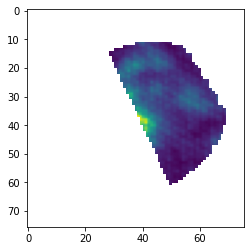

In [120]:
sample = 2
min_snr = 3
max_radii = 1.5

h, l, t = cut(sample, min_snr, max_radii)
snr = get_ha_snr(sample)
lead_error = np.ma.sum(l / snr)
trail_error = np.ma.sum(t / snr)

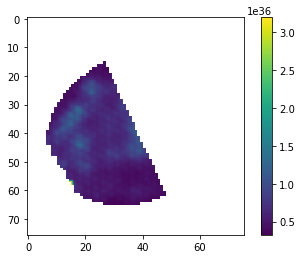

In [123]:
plt.imshow(l / snr)
plt.colorbar()
plt.imshow()

In [94]:
type(get_ha_snr(2))

numpy.ndarray

In [101]:
sum_error(2, 3, 1.5)

(8.70644468281625e+38, 7.06901483737372e+38)

In [99]:
sum_stat(2, 3, 1.5)

(7.385801845874348e+40, 4.0092121618613787e+40)